In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
import math
import sys
sys.path.insert(0,'/usr/local/lib/python3.5/dist-packages/')
from joblib import Parallel, delayed
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d import Axes3D
import copy as copy
from scipy.spatial import ConvexHull
import matplotlib.tri as mtri
import pickle
from scipy.integrate import odeint
import random
import time

In [2]:
def saveThing(thing,file):
    with open(file,'wb') as fil:
        pick = pickle.Pickler(fil,protocol=4)
        pick.dump(thing)
        pick.clear_memo()
def openThing(file):
    with open(file,'rb') as fil:
        pick = pickle.Unpickler(fil)
        thing = pick.load()
    return thing

In [3]:
def Tn(x,n):
    return np.cos(n*np.arccos(x))

def JCheb(xList,rho,n=0):
    if n == 0:
        n = len(xList)
    return np.array([[rho**(-d)*Tn(x,d) for d in range(n)] for x in xList])

# k = # coeffs, assume |y^n(t)/n!|< CR^(-n)
# for small k, use table values. 
# this is an asymptotic formula that assumes R > 1. 
def Ellipse_params(C, R, k):  
    k = k-1
    rn1 = R - 2*k*R + k**2*R 
    rn2 = -np.sqrt( k**2-2*k + R**2 - 2*k*R**2 + k**2*R**2) 
    d = (k-2)*k
    r = (rn1 + rn2)/d 

    M = C*R/(R-r)
    rho = r + np.sqrt(r**2 + 1)
    return np.array([rho, M, r])

In [4]:
def SIR(beta, gamma, I0, xList):
    R0 = 0
    S0 = 1 - I0 - R0
    y0 = S0, I0, R0
    ret = odeint(deriv, y0, xList, args=(beta, gamma))
    S, I, R = ret.T
    return np.array([S, I]).T

In [6]:
S_sym, I_sym, R_sym, t_sym = sy.symbols("S_sym I_sym R_sym t_sym")
dS_sym, dI_sym, dR_sym = sy.symbols("dS_sym dI_sym dR_sym")
beta_sym, gamma_sym = sy.symbols("beta_sym gamma_sym")

dS_sym = -beta_sym*S_sym(t_sym)*I_sym(t_sym)
dI_sym = beta_sym*S_sym(t_sym)*I_sym(t_sym) - gamma_sym*I_sym(t_sym)
dR_sym = gamma_sym*I_sym(t_sym)

derivSubs = [(sy.Derivative(S_sym(t_sym), t_sym),dS_sym),(sy.Derivative(I_sym(t_sym), t_sym),dI_sym)]

derivs = [I_sym(t_sym),dI_sym]
for i in range(1):
    derivs.append(derivs[-1].diff(t_sym).subs(derivSubs))

In [7]:
def evalDeriv(S,I,beta,gamma,der):
    S_sym, I_sym, R_sym, t_sym = sy.symbols("S_sym I_sym R_sym t_sym")
    dS_sym, dI_sym, dR_sym = sy.symbols("dS_sym dI_sym dR_sym")
    beta_sym, gamma_sym = sy.symbols("beta_sym gamma_sym")
    return np.array([der.subs([(I_sym(t_sym),I[i]),(S_sym(t_sym),S[i]),(beta_sym,beta),(gamma_sym,gamma)]) for i in range(len(S))])

len(derivs)

3

In [8]:
def deriv(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def useParams(S,I,xList,beta,gamma,C=1,R=2):
    for i in range(len(xList)):
        der = derivs[i]
        terms = abs(evalDeriv(S,I,beta,gamma,der)/math.factorial(i))
        for t in terms:
            if t > C*R**(-i):
                return False
    return True
    
def findParam(xList,betaRange,gammaRange,C=1,R=2):
    beta = betaRange*random.random()
    gamma = gammaRange*random.random()
    I0 = np.random.rand()
    
    pointVals = SIR(beta,gamma,I0,xList)
    S,I = pointVals.T
    
    if useParams(S,I,xList,beta,gamma,C=C,R=R):
        return {'xList':xList,'I':I,'S':S,'beta':beta,'gamma':gamma}

In [ ]:
xList = np.linspace(0, 2, 11)

betaRange = 15.0
gammaRange = 15.0
C=1
R=2

start_time = time.time()

points = Parallel(n_jobs=14)(delayed(findParam)(xList,betaRange,gammaRange,C=C,R=R) for i in range(300*10**4))

sampledPoints = []
for p in points:
    if p != None:
        sampledPoints.append(p)
        
print(len(points))
print(len(sampledPoints))
elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [ ]:
saveThing(sampledPoints,'sampledPoints_SIR_11Points.pckl')

In [87]:
rho,M,r = Ellipse_params(C,R,len(xList))

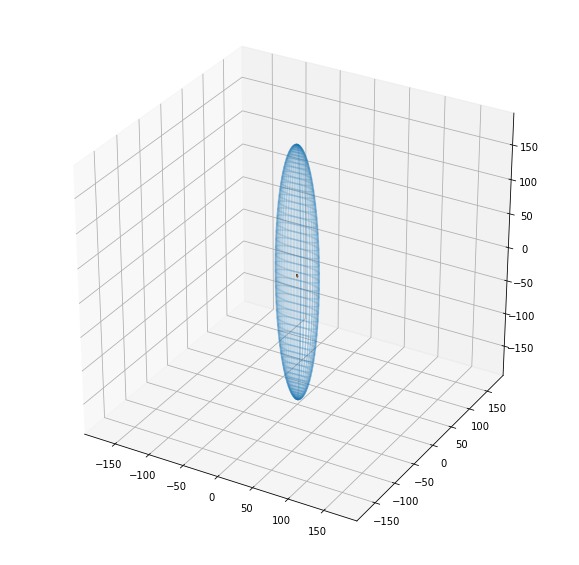

In [88]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

### WIREFRAME ###
xList = np.array(sampledPoints[0]['xList'])
xShifted = xList - (max(xList)+min(xList))/2
J = JCheb(xShifted,rho)
u,s,vt = np.linalg.svd(J)

theta = np.linspace(0, 2 * np.pi, 200)
phi = np.linspace(0, np.pi, 200)

radius = M*np.sqrt(4*len(xList)-3)
x = radius*np.outer(np.cos(theta), np.sin(phi))
y = radius*np.outer(np.sin(theta), np.sin(phi))
z = radius*np.outer(np.ones_like(theta), np.cos(phi))

x_rot = copy.deepcopy(x)
y_rot = copy.deepcopy(y)
z_rot = copy.deepcopy(z)

Jacob = np.dot(np.diag(s[0:3]),[[0,0,1],[0,1,0],[1,0,0]])
for i in range(len(x_rot)):
    for j in range(len(x_rot[0])):
        vect = [x_rot[i][j],y_rot[i][j],z_rot[i][j]]
        vect_rot = np.dot(Jacob,vect)
        x_rot[i][j] = vect_rot[1]
        y_rot[i][j] = vect_rot[2]
        z_rot[i][j] = vect_rot[0]

ax.plot_wireframe(x_rot, y_rot, z_rot, rstride=5, cstride=4, alpha=0.2,label='Bound from Chebychev')

### MODEL MANIFOLD ###

proj = np.dot([p['I'] for p in sampledPoints],u)

pointsX = proj[:,1]
pointsY = proj[:,2]
pointsZ = proj[:,0]

ax.scatter3D(pointsX,pointsY,pointsZ,color='C1',edgecolors='black',s=1,linewidth=0.1,label='Model Predictions')

# Adjustment of the axes, so that they all have the same span:
max_radius = radius*s[0]
for axis in 'xyz':
    getattr(ax, 'set_{}lim'.format(axis))((-max_radius, max_radius))
#ax.view_init(0,0)
#ax.set_xlabel('first time point')
#ax.set_ylabel('second time point')
#ax.set_zlabel('third time point')

plt.show()
#trianglePlotBound(proj,['C1' for p in sampledPoints0],s,len(xList),dim=4)

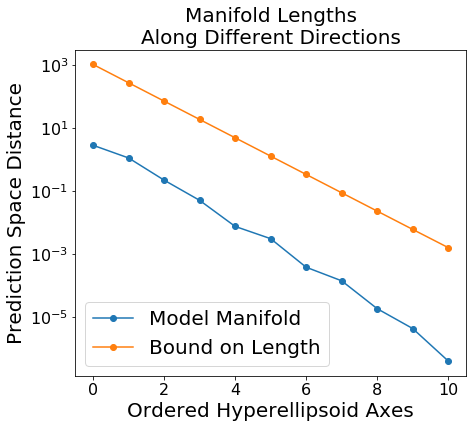

In [89]:
lengths = np.array([max(proj[:,i])-min(proj[:,i]) for i in range(proj.shape[1])])
blur = 4*M*rho**(1-len(xList))/(rho-1)
polyLengths = 2*radius*s
approxLengths = [2*M*np.sqrt(2*len(xList)**2-3*len(xList))*rho**(2-j)/np.sqrt(rho**2-1) + blur for j in range(len(xList))]

plt.figure(figsize=(7,6))
plt.plot([i for i in range(len(lengths))],lengths,label='Model Manifold',marker='o')
#plt.plot([i for i in range(len(polyLengths))],polyLengths,label=r'$\ell_j(H_P)$',marker='o')
plt.plot([i for i in range(len(approxLengths))],approxLengths,label='Bound on Length',marker='o')
plt.yscale('log')
#limits = np.array([min([min(x) for x in [lengths, polyLengths]]),max([max(x) for x in [lengths, polyLengths]])])
#plt.ylim(limits)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Ordered Hyperellipsoid Axes',fontsize=20)
plt.ylabel('Prediction Space Distance',fontsize=20)
plt.title('Manifold Lengths\nAlong Different Directions',fontsize=20)
plt.legend(fontsize=20,loc='lower left')
plt.show()

In [90]:
lengths

array([  2.77188115e+00,   1.09747722e+00,   2.17617985e-01,
         4.98137928e-02,   7.44148627e-03,   3.04085191e-03,
         3.78269326e-04,   1.40515652e-04,   1.83934097e-05,
         4.32307968e-06,   4.04832385e-07])

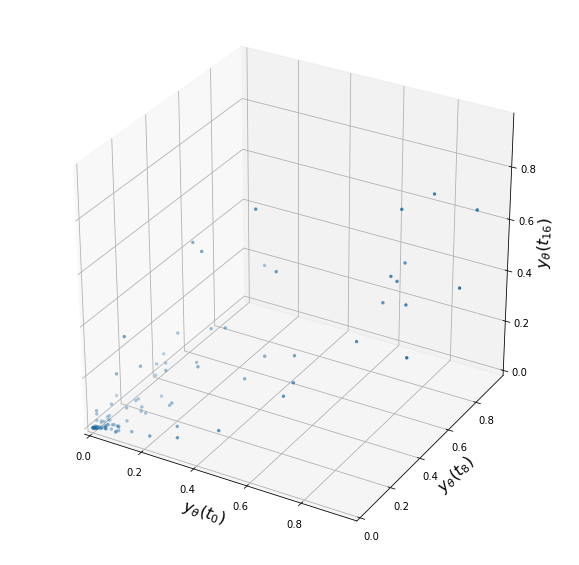

In [93]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

#proj = np.dot([p['pointVals'] for p in sampledPoints0],u)

allPoints = np.array([p['I'] for p in sampledPoints])

pointsX = allPoints[:,0]
pointsY = allPoints[:,5]
pointsZ = allPoints[:,10]

ax.scatter3D(pointsX,pointsY,pointsZ,color='C0',edgecolors='black',s=10,linewidth=0.1,label='Model Predictions')

# Adjustment of the axes, so that they all have the same span:
max_radius = max([max(pointsX),max(pointsY),max(pointsZ)])
for axis in 'xyz':
    getattr(ax, 'set_{}lim'.format(axis))((0, max_radius))
#ax.view_init(0,0)
ax.set_xlabel(r'$y_{\theta}(t_{0})$',fontsize=16)
ax.set_ylabel(r'$y_{\theta}(t_{8})$',fontsize=16)
ax.set_zlabel(r'$y_{\theta}(t_{16})$',fontsize=16)

plt.show()
#trianglePlotBound(proj,['C1' for p in sampledPoints0],s,len(xList),dim=4)
#trianglePlot(allPoints,['C1' for p in sampledPoints0],dim=5)

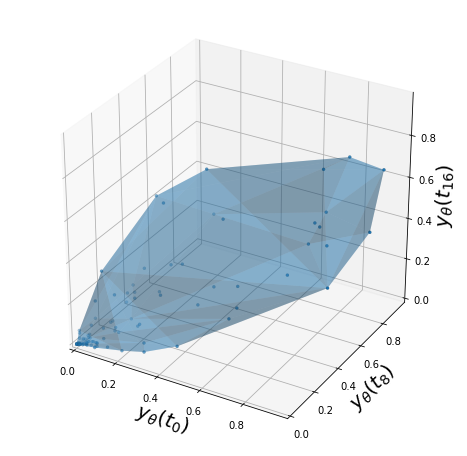

In [94]:
hullPoints = np.array([pointsX,pointsY,pointsZ]).T
hull = ConvexHull(hullPoints)
tri = mtri.Triangulation(pointsX, pointsY, triangles=hull.simplices)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(pointsX,pointsY,pointsZ,color='C0',edgecolors='black',s=10,linewidth=0.1,label='Model Predictions with \nDifferent Parameters ('+r'$\theta$'+')')
ax.plot_trisurf(tri, pointsZ, color='C0',alpha=0.3)

for axis in 'xyz':
    getattr(ax, 'set_{}lim'.format(axis))((0, max_radius))

ax.set_xlabel(r'$y_{\theta}(t_{0})$',fontsize=20)
ax.set_ylabel(r'$y_{\theta}(t_{8})$',fontsize=20)
ax.set_zlabel(r'$y_{\theta}(t_{16})$',fontsize=20)

#label1 = mlines.Line2D([], [], color='C0',marker='o',linewidth=0, markersize=10, label='Model Predictions at '+r'$(t_0,t_{8},t_{16})$'+'\nFor Different Model Parameters '+r'$(\theta)$')
#plt.legend(handles=[label1],fontsize=20,loc = 'upper right')

plt.show()

2D Case (variable infection/recovery rates)

In [51]:
def polyDeg(xList):
    return math.ceil(np.sqrt(1/4+2*len(xList))-3/2)

nX = 5
ns = 3
xRange = np.linspace(0,2,nX)
sRange = np.linspace(0,2,ns)
xList = [[x,s] for x in xRange for s in sRange]

In [52]:
S_sym, I_sym, R_sym, t_sym, s_sym = sy.symbols("S_sym I_sym R_sym t_sym s_sym")
dS_sym, dI_sym, dR_sym = sy.symbols("dS_sym dI_sym dR_sym")
beta_sym, gamma_sym = sy.symbols("beta_sym gamma_sym")
Ebeta_sym, Egamma_sym = sy.symbols("Ebeta_sym Egamma_sym")

dS_sym = -beta_sym*sy.exp(Ebeta_sym*s_sym)*S_sym(t_sym)*I_sym(t_sym)
dI_sym = beta_sym*sy.exp(Ebeta_sym*s_sym)*S_sym(t_sym)*I_sym(t_sym) - gamma_sym*sy.exp(Egamma_sym*s_sym)*I_sym(t_sym)
dR_sym = gamma_sym*sy.exp(Egamma_sym*s_sym)*I_sym(t_sym)

derivSubs = [(sy.Derivative(S_sym(t_sym), t_sym),dS_sym),(sy.Derivative(I_sym(t_sym), t_sym),dI_sym)]

P = polyDeg(xList)

derivs = [I_sym(t_sym),dI_sym]
for i in range(P+1-2):
    derivs.append(derivs[-1].diff(t_sym).subs(derivSubs))
    
derivsMat = [derivs]

for i in range(P+1-1):
    row = [e.diff(s_sym) for e in derivsMat[-1]]
    derivsMat.append(row)
    
def evalDeriv2D(S,I,s,beta,gamma,Ebeta,Egamma,der):
    S_sym, I_sym, R_sym, t_sym, s_sym = sy.symbols("S_sym I_sym R_sym t_sym s_sym")
    dS_sym, dI_sym, dR_sym = sy.symbols("dS_sym dI_sym dR_sym")
    beta_sym, gamma_sym, Ebeta_sym, Egamma_sym = sy.symbols("beta_sym gamma_sym Ebeta_sym Egamma_sym")
    return der.subs([(I_sym(t_sym),I),(S_sym(t_sym),S),(s_sym,s),
                     (beta_sym,beta),(gamma_sym,gamma),
                     (Ebeta_sym,Ebeta),(Egamma_sym,Egamma)])


In [57]:
def useParams2D(points,beta,gamma,Ebeta,Egamma,P,C=1,R=1):
    
    S,I,s = points
    
    for p in range(P+1):
        for n in range(p+1):
            der = derivsMat[n][p-n]
            term = abs(evalDeriv2D(S,I,s,beta,gamma,Ebeta,Egamma,der))/(math.factorial(n)*math.factorial(p-n))
            if term > C*R**(-p):
                return False
    return True

def findParam2D(xRange,sRange,betaRange,gammaRange,EbetaRange,EgammaRange,C=1,R=2):
    beta = betaRange*random.random()
    gamma = gammaRange*random.random()
    I0 = np.random.rand()
    Ebeta = EbetaRange*random.random()
    Egamma = EgammaRange*random.random()
    
    
    pointVals = [SIR(beta*np.exp(-Ebeta*s),gamma*np.exp(-Ebeta*s),I0,xRange) for s in sRange]
    
    P = polyDeg(xList)
    
    idx = 0
    goodParams = True
    for S,I in pointVals[idx]:
        if useParams2D([S,I,sRange[idx]],beta,gamma,Ebeta,Egamma,P,C=C,R=R):
            pass
        else:
            goodParams = False
            break
    if goodParams:
        return {'xList':xList,'pointVals':pointVals,'beta':beta,'gamma':gamma}

In [81]:
betaRange = 15.0
gammaRange = 15.0
EbetaRange = 2
EgammaRange = 2
C=1
R=2

start_time = time.time()

points = Parallel(n_jobs=8)(delayed(findParam2D)(xRange,sRange,betaRange,gammaRange,EbetaRange,EgammaRange,C=C,R=R) for i in range(2*10**6))

sampledPoints = []
for p in points:
    if p != None:
        sampledPoints.append(p)
        
print(len(points))
print(len(sampledPoints))
elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

2000000
15704
05:17:23


In [84]:
saveThing(sampledPoints,'2DSIRSampling_15Points.pckl')

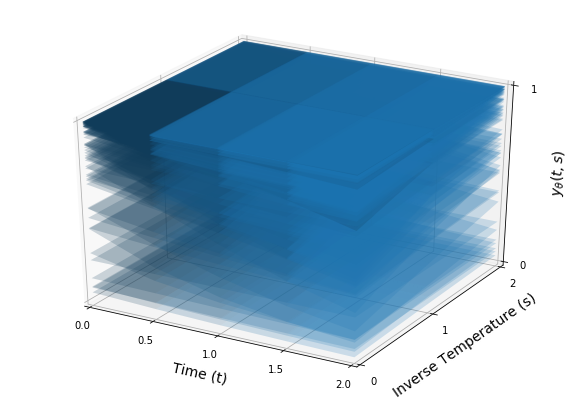

In [79]:
X,Y = np.meshgrid(xRange,sRange)

xRange = np.linspace(0,2,nX)
betaRange = np.linspace(0,2,nBeta)
xList = [[x,beta] for x in xRange for beta in betaRange]


fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

for p in sampledPoints:
    pointVals = p['pointVals']
    
    Z = np.array([[pointVals[j][i][0] for i in range(len(xRange))] for j in range(len(sRange))])

    ax.plot_surface(X,Y,Z,color='C0',alpha=0.2)

ax.set_xticks(xRange)
#ax.set_xticklabels([r'$t_1=0$',r'$t_2=0.5$',r'$t_3=1$'])
ax.set_yticks(sRange)
#ax.set_yticklabels([r'$\beta_1=0$',r'$\beta_2=0.25$',r'$\beta_3=0.5$',r'$\beta_4=0.75$',r'$\beta_5=1$'])

"""ax.set_xticks([0,1,2])
ax.set_xticklabels([r'$t_1=0$',r'$t_2=1$',r'$t_3=2$'])
ax.set_yticks([0,0.5,1,1.5,2])
ax.set_yticklabels([r'$\beta_1=0$',r'$\beta_2=0.5$',r'$\beta_3=1$',r'$\beta_4=1.5$',r'$\beta_5=2$'])"""

ax.set_zticks([0,1])
ax.set_zticklabels(['0','1'])
    
ax.set_xlabel('\nTime (t)',fontsize=14)
ax.set_ylabel('\nInverse Temperature (s)',fontsize=14)
ax.set_zlabel('\n'+r'$y_{\theta}(t,s)$',fontsize=14)

ax.set_xlim([0,2])
ax.set_ylim([0,2])
ax.set_zlim([0,1])

#label1 = mpatches.Patch(color='C0', label='Exponentials')
#plt.legend(handles=[label1],fontsize=14)

plt.show()